### Notebook to develop threshold for modified NDSI (MNDSI) for identifying snow in PlanetScope 4-band imagery
Rainey Aberle

December 2021

### Import packages

In [1]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import earthpy.spatial as es
import matplotlib.pyplot as plt
import matplotlib

### Define paths to directories

In [2]:
# base directory
basepath = '/Users/raineyaberle/Research/PhD/Wolverine/'
# image directory
impath = basepath+'imagery/Planet/2021-04-20_2021-08-25/SR-stitched/'
# output folder
outpath = basepath+'imagery/Planet/2021-04-20_2021-08-25/SCA/'

### Define Area of Interest (AOI)
#### Read in a shapefile with AOI polygon

In [3]:
# Load shapefile
fn = basepath+'GIS_data/wolverine_RGI.shp'
AOI = gpd.read_file(fn)
print('Original shapefile CRS:',AOI.crs)

# Reproject to imagery CRS if necessary
AOI = AOI.to_crs(32606)

# print information
print('Reprojected shapefile CRS: ',AOI.crs)
print('Shapefile bounds:',AOI.boundary)

Original shapefile CRS: epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTILINESTRING ((393342.531 6698475.452, 3933...
dtype: geometry


### Load image and shapefiles for tuning threshold: digitized snow line & transects

In [4]:
# image
os.chdir(impath) # change directory
im_name = glob.glob('20210821.tif')
print('Image: ',im_name[0])
print('')

# snowline
sl_fn = basepath+'GIS_data/digitized_snowline_picks/20210821_snowline.shp'
sl = gpd.read_file(sl_fn) # snowline
print('Snowline')
print('CRS: ',sl.crs)
# Reproject to imagery CRS if necessary
sl = sl.to_crs(32606)
# print information
print('Reprojected shapefile CRS: ',sl.crs)
print('Shapefile bounds:',sl.boundary)
print('')

# transect 
ts_fn = basepath+'GIS_data/digitized_snowline_picks/transect.shp'
ts = gpd.read_file(ts_fn) # snowline
print('Transect')
print('CRS:',ts.crs)
# Reproject to imagery CRS if necessary
ts = ts.to_crs(32606)
# print information
print('Reprojected CRS: ',ts.crs)
print('Bounds:',ts.boundary)

Image:  20210821.tif

Snowline
CRS:  epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTIPOINT (393148.827 6699387.404, 396547.495...
dtype: geometry

Transect
CRS: epsg:4326
Reprojected CRS:  epsg:32606
Bounds: 0    MULTIPOINT (395486.185 6701902.154, 394569.659...
dtype: geometry


### Plot MNDSI along transect for each image

/Users/raineyaberle/opt/anaconda3/lib/python3.8/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b1 - b2) / (b1 + b2)


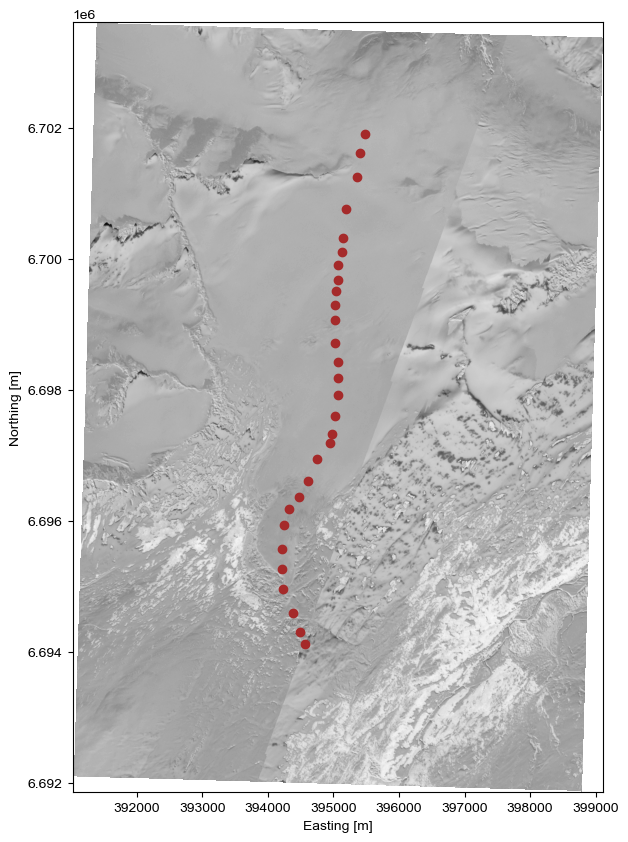

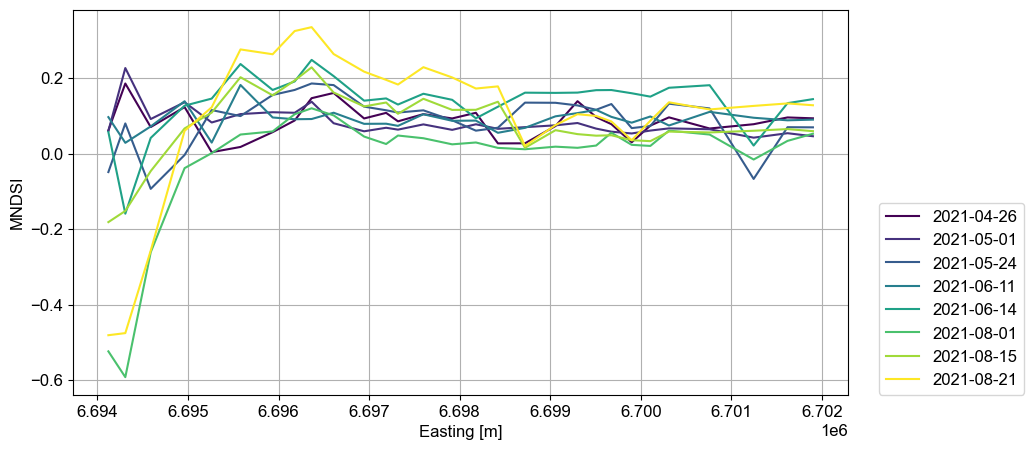

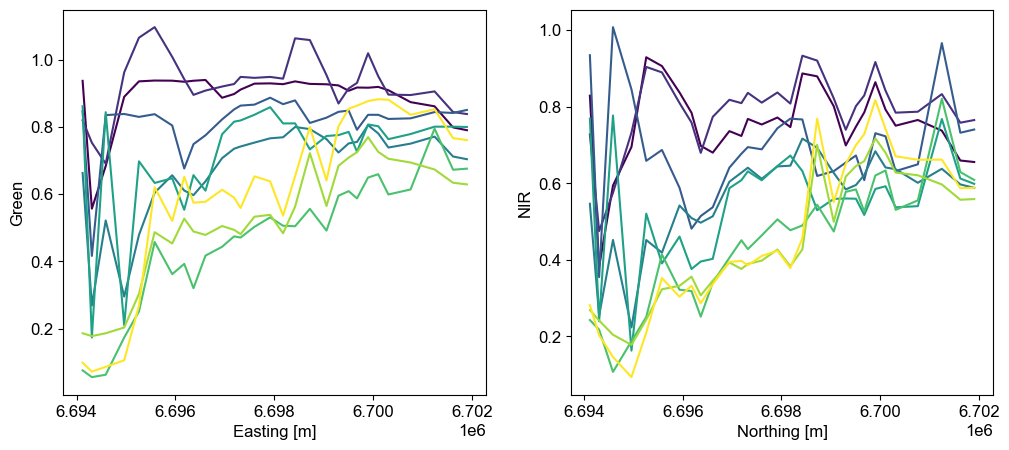

In [5]:
# grab cropped image names
os.chdir(impath) # change directory
im_names = glob.glob('*.tif')
im_names.sort() # sort file names by date

# set up figures
fig1, ax1 = plt.subplots(1,1,figsize=(10,10))
plt.rcParams.update({'font.size': 12, 'font.sans-serif': 'Arial'})
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
fig2, ax2 = plt.subplots(1,1, figsize=(10,5))
plt.rcParams.update({'font.size': 12, 'font.sans-serif': 'Arial'})
ax2.set_xlabel('Easting [m]')
ax2.set_ylabel('NDSI')
fig3, (ax3, ax4) = plt.subplots(1,2,figsize=(12,5))
plt.rcParams.update({'font.size': 12, 'font.sans-serif': 'Arial'})
ax3.set_xlabel('Easting [m]')
ax3.set_ylabel('Green')
ax4.set_xlabel('Northing [m]')
ax4.set_ylabel('NIR')
# color scheme for plotting lines in loop
colors = plt.cm.viridis(np.linspace(0,1,len(im_names)))  

# extract transect points from geometry
ts_pts = [i for i in ts.geometry]
ts_x,ts_y = ts_pts[0].coords.xy
ts_coords = np.dstack((ts_x,ts_y)).tolist()

# loop through images
dates = []
i = 0 # index for color plotting
for im_name in im_names:
        
    # open image
    im = rio.open(im_name)

    # extract date from image name
    date = im_name[0:4] + '-' + im_name[4:6] + '-' + im_name[6:8]
    dates = dates + [np.datetime64(date)]

    # define bands 
    scalar = float(10000) # scalar multiplier
    blue = im.read(1).astype(float) / scalar
    green = im.read(2).astype(float) / scalar
    red = im.read(3).astype(float) / scalar
    nir = im.read(4).astype(float) / scalar 
    # compute MNDSI
    mndsi = es.normalized_diff(green, nir) 

    # sample raster values at transect coordinates
    ts_rv = [x for x in im.sample(ts_coords[0])]
    # calculate MNDSI at points
    ts_green = []
    ts_nir = []
    ts_mndsi = []
    for s in ts_rv:
        ts_mndsi = ts_mndsi + [es.normalized_diff(s[1].astype(float)/scalar, s[3].astype(float)/scalar)]
        ts_green = ts_green + [s[1].astype(float)/scalar]
        ts_nir = ts_nir + [s[3].astype(float)/scalar]
        
    # plot first image and transect points on first loop iteration
    if i==1:
        show(mndsi, transform=im.transform, cmap='Greys', ax=ax1)
        ax1.scatter(ts_x, ts_y, color='brown')
        
    # plot values 
    ax2.plot(ts_y, ts_mndsi, label=date, color=colors[i])
    ax3.plot(ts_y, ts_green, label=date, color=colors[i])
    ax4.plot(ts_y, ts_nir, label=date, color=colors[i])

    i=i+1 

ax2.legend(loc=(1.04,0.0))
ax2.grid()
plt.show()

### Identify snow by adjusting thresholds

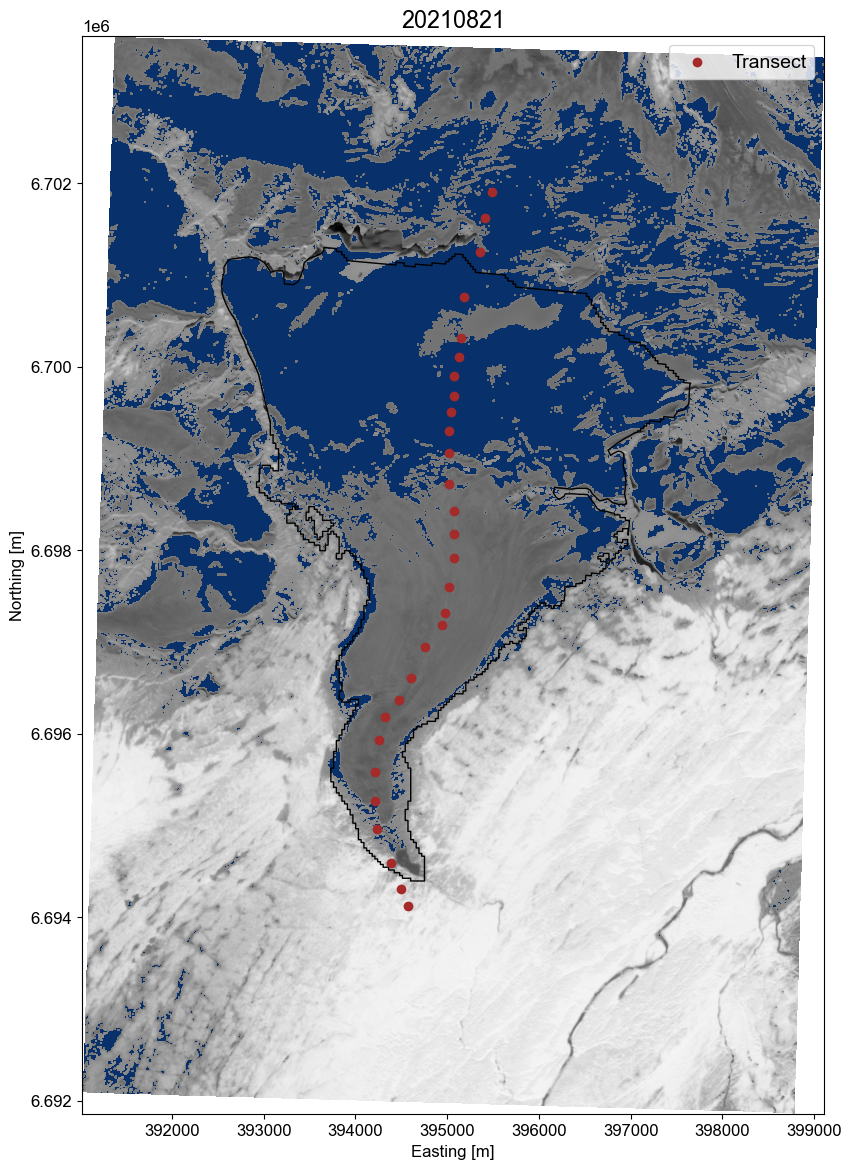

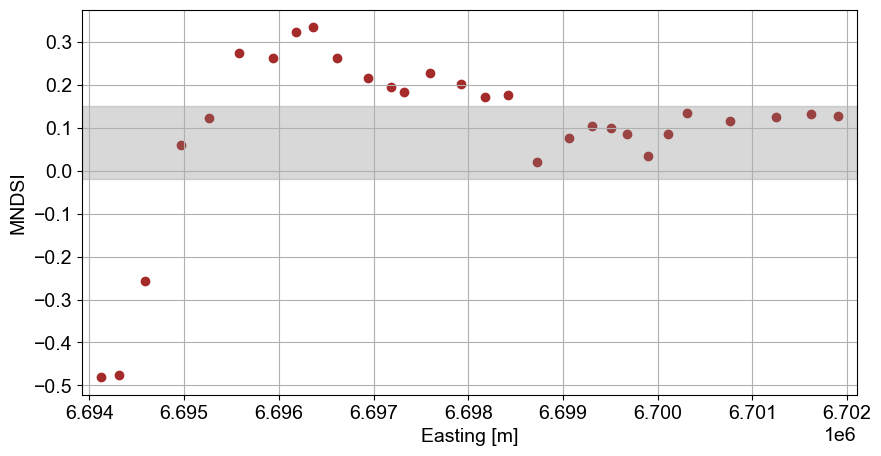

In [7]:
# Determine thresholds
thresh_min = -0.02
thresh_max = 0.15

# threshold MNDSI to determine snow cover
snow = np.where((mndsi>thresh_min) & (mndsi<thresh_max),1,np.nan)

# plot 
fig3, ax1 = plt.subplots(1,1,figsize=(14,14))
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# MNDSI, snow, snowline, and transect locations
show(mndsi, transform=im.transform, cmap='Greys', ax=ax1)
show(snow, transform=im.transform, cmap='Blues_r', ax=ax1) #, clim(0,1)
AOI.plot(facecolor='none', edgecolor='black', label='AOI', ax=ax1)
#sl.plot(linestyle='-', color='cyan', label='Snowline', ax=ax1)
ax1.scatter(ts_x, ts_y, color='brown', label='Transect')
plt.title(im_name[0:8])
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.legend()
# MNDSI values along transect
fig4, ax1 = plt.subplots(1,1, figsize=(10,5))
ax1.set_xlim(np.min(ts_y)-200, np.max(ts_y)+200)
rect=matplotlib.patches.Rectangle((ax1.get_xlim()[0],thresh_min),ax1.get_xlim()[1]-ax1.get_xlim()[0],thresh_max-thresh_min, 
                        fill=True, color="grey", alpha=0.3, label='threshold')
plt.gca().add_patch(rect)
ax1.scatter(ts_y, ts_mndsi, color='brown', label='Transect')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('MNDSI')
#ax1.set_ylim(-0.5,0.5)
ax1.grid()
plt.show()